# How To Run This Notebook

1. Run all cells until "Graphing Usage" section. 
2. Load data by calling `load_df(path)`, where `path` is filepath to csv file.
3. Get r_bg, r_np, data by calling `r_bg, r_np, df = cleanup(df)`.
4. Optionally remove outliers by calling `df = remove_outliers(df)`.
5. Graph results by calling `graph_firstRun(df, ["fg"])` where `["fg"]` can be replaced with any subset (e.g. `["bg", "np"]`) or omitted entirely (e.g. `graph_firstRun(df)`) to graph all three.

### Imports 

In [107]:
import random
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# import csv 
# path = path to csv file
# reference: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
def load_df(path):
    df = pd.read_csv(path, header=None)
    return df

### Data Preprocessing Helper Functions 
(for datasets with schema (site, rank, r_time, r_time_eq, case, label, r_bg, r_np) only)

In [3]:
# makes new rows with clean values, e.g. 'rank=1' --> '1'
# reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
def row_cleanup(df):
    
    df['site'] = df[0].apply(lambda x: x[5:])
    df['rank'] = df[1].apply(lambda x: x[5:])
    df['r_time'] = df[2].apply(lambda x: x[7:])
    df['heavy_load_rtime'] = df[3].apply(lambda x: x[9:])
    df['html_parsing_time'] = df[4].apply(lambda x: x[11:])
    df['case'] = df[5].apply(lambda x: x[5:])
    df['label'] = df[6].apply(lambda x: x[6:])
    df['r_bg'] = df[7].apply(lambda x: x[5:])
    df['r_np'] = df[8].apply(lambda x: x[5:])
    
    return df

In [4]:
# drops unnecessary columns, converts to numeric, and gets rid of negatives 
# references:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
def col_cleanup(df):
    # drop cols
    df = df.drop(columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 'r_bg', 'r_np'])
    
    # convert string 'na' to None 
    df.loc[df['heavy_load_rtime'] == "na", "heavy_load_rtime"] = None
    df.loc[df['html_parsing_time'] == "na", "html_parsing_time"] = None
    
    # convert to numeric types
    df = df.astype({'rank':'int', 'r_time':'float', 'heavy_load_rtime':'float', 
                         'html_parsing_time':'float'})
    # get rid of negatives
    df['html_parsing_time'] = abs(df['html_parsing_time'])
    
    return df

In [5]:
# cleans up dataset and returns baseline vals and clean dataframe
# reference: https://pandas.pydata.org/docs/reference/api/pandas.unique.html
def cleanup(df):
    
    df = row_cleanup(df)
    r_bg = float(df['r_bg'].unique()[0])
    r_np = float(df['r_np'].unique()[0])
    df = col_cleanup(df)
    
    return r_bg, r_np, df

In [6]:
# removes outliers for a single label type
# e.g. of all bg r_times, remove outliers 
# references
# https://online.stat.psu.edu/stat200/lesson/3/3.2
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
def remove_outlier_with_label(df, label):
    
    label_df = df[df["label"] == label]
    Q1 = label_df.describe().iloc[4, 1]
    Q3 = label_df.describe().iloc[6, 1]
    IQR = Q3 - Q1

    df_filtered = label_df[label_df['r_time'] < (Q3 + 1.5*IQR)]
    df_filtered = df_filtered[df_filtered['r_time'] > (Q1 - 1.5*IQR)]
    return df_filtered

# removes outliers
def remove_outliers(df):
    
    labels = ["np", "bg", "fg"]
    filtered_dfs = []
    
    for label in labels:
        filtered_dfs.append(remove_outlier_with_label(df, label))
        
    return pd.concat(filtered_dfs)
    

In [7]:
# separates dataset into the separate cases
def get_cases(df):
    df_1 = df[df["case"] == "1"]
    df_2 = df[df["case"] == "2"]

    return df_1, df_2

### DELTA

In [8]:
# returns the delta thresholds using the empirical 68-95-99.7 rule
# inputs: dataframe, label (e.g. 'bg', 'np'), confidence level
# output: delta interval of form [lower_bound, upper_bound]
# references:
# https://en.wikipedia.org/wiki/68-95-99.7_rule
def get_delta(df, label, interval=3):
    
    # remove outliers
    df = remove_outliers(df)
    
    # get interval
    df = df[df['label'] == label]
    mean = df['r_time'].mean()
    sd = df['r_time'].std()
    
    interval = [mean - interval*sd, mean + interval*sd]
    return interval

### Get data for SVM: 
    Case 1: fg (1) vs bg (0) --> measure heavy load rtime
    Case 2: fg (1) vs np (0) --> measure html loading time

In [86]:
# removes bg and makes a binary label column 
def get_svm_df(df, case, outliers=True):
    
    # remove outliers to train svm
    if outliers == False:
        df = remove_outliers(df)
    interval = []
    df_svm = df
    
    if case == "1":
        df_svm = df[df["label"] != 'np']
        interval = get_delta(df, 'bg')
        
    elif case == "2":
        df_svm = df[df["label"] != 'bg']
        interval = get_delta(df, 'np')
    
    else: 
        print("Error: invalid case")
        return None
    
    df_svm.loc[df_svm['label'] == "fg", "label"] = "1"
    df_svm.loc[df_svm['label'] != "1", "label"] = "0"
    df_svm = df_svm.rename(columns={'label':'svm_label'})
    df_svm = df_svm.astype({'svm_label':'int'})
    
    # for each site rank for fg sites: 
    # if fg r_time does not overlap with np/bg confidence intervals, remove that rank from the dataset entirely
    # outliers are removed --> indices may not match perfectly 
    fg_df = df[df["label"] == "fg"]
#     print(interval)
    overlap = fg_df[fg_df["r_time"] >= interval[0]]
#     print(overlap)
    overlap = overlap[overlap["r_time"] <= interval[1]]
#     print(overlap)
    overlapping_ranks = set(overlap["rank"])
    
    # only keep overlaps
    df_svm = df_svm[df_svm["rank"].isin(overlapping_ranks)]
    
    return df_svm

In [93]:
svm_df = get_svm_df(case1, "1")
get_splits(svm_df, 'r_time', 'heavy_load_rtime')

{86, 51, 54, 55}
8
4


(array([[0.51828534, 1.50116492],
        [0.67710797, 0.48716313],
        [1.06698986, 0.95482373],
        [0.53603229, 0.42318092]]),
 array([1, 1, 0, 1]),
 array([[0.63317312, 1.06430627],
        [0.65218442, 0.40280436],
        [1.02815139, 1.50770399],
        [1.03195076, 0.79976263]]),
 array([0, 1, 0, 0]))

In [83]:
svm1 = get_svm(df=case1, case="1")

                                    site  rank    r_time  heavy_load_rtime  \
151                  partner.netflix.net    51  0.518285          1.501165   
152             prod.partner.netflix.net    52  0.280303          1.015737   
153                     fe.apple-dns.net    53  0.109592          0.623576   
154      preapp.prod.partner.netflix.net    54  0.677108          0.487163   
155                     prod.netflix.com    55  0.536032          0.423181   
156                push.prod.netflix.com    56  0.196458          0.662895   
157                     mtalk.google.com    57  0.158034          0.595476   
158                          aaplimg.com    58  0.307150          0.372182   
159                          youtube.com    59  0.211584          0.659422   
160                   gateway.icloud.com    60  0.292579          0.764720   
161                         digicert.com    61  0.195746          0.415650   
162                              msn.com    62  0.294678        

In [92]:
# returns training and testing splits
# reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html
def get_splits(df, x1, x2):
    X_pd = pd.DataFrame()
    X_pd[x1] = df[x1]
    X_pd[x2] = df[x2]
    X = X_pd.to_numpy()
    y = df['svm_label'].to_numpy()
    
    # X,y are ordered 
    
    # get training and testing sets
    # 70% train, 10% validation, 20% test
    size = len(df)
    print(size)
    split_idx = (size // 5) * 4
    print(split_idx)
    indices = [i for i in range(size)]
    random.shuffle(indices)
    X_train = X[indices[:split_idx]]
    y_train = y[indices[:split_idx]]
    X_test = X[indices[split_idx:size]]
    y_test = y[indices[split_idx:size]]
    
    return X_train, y_train, X_test, y_test
    

In [82]:
def get_svm_splits(df, case):
    
    df_svm = get_svm_df(df, case)
    if len(df_svm.svm_label) == 0:
        return None
    
    if case == "1":
        X_train, y_train, X_test, y_test = get_splits(df_svm, 'r_time', 'heavy_load_rtime')
    elif case == "2":
        X_train, y_train, X_test, y_test = get_splits(df_svm, 'r_time', 'html_parsing_time')
    else:
        return None
    
    return X_train, y_train, X_test, y_test

### Make SVM

In [42]:
# given a dataframe containing either case1 data or case2 data, and the case number,
# trains and tests a SVM model 
# returns the trained SVM model 
def get_svm(df, case):
    # get train and test splits
    splits = get_svm_splits(df, case)
    if splits:
        X_train, y_train, X_test, y_test = get_svm_splits(df, case)
    else:
        print("No overlapping FG points.")
        return None
    
    print("Shapes: ")
    print(f"X_train:{X_train.shape}, y_train:{y_train.shape}, X_test:{X_test.shape}, y_test:{y_test.shape}")
    
    # make classifier
    # reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    svm = SVC(kernel='linear', random_state=0)
    svm.fit(X_train, y_train)

    train_pred = svm.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print('Training Accuracy:', "{:.3f}".format(train_acc))

    test_pred = svm.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print('Testing Accuracy:', "{:.3f}".format(test_acc))
    
    return svm

### Accuracy

In [12]:
# Calculates bg vs np accuracy using delta
# references:
    # https://pandas.pydata.org/docs/reference/api/pandas.concat.html
    
def bg_np_acc(df, include_outliers = True):
    
    # depending on include_outliers, np_df and bg_df will or will not include outliers
    if include_outliers == False:
        new_df = remove_outliers(df)
        np_df = new_df[new_df['label'] == 'np']
        bg_df = new_df[new_df['label'] == 'bg']
    else:
        np_df = df[df['label'] == 'np']
        bg_df = df[df['label'] == 'bg']
        
    # count number of np outside interval
    np_interval = get_delta(df, 'np')
    np_err = len(pd.concat([np_df[np_df['r_time'] < np_interval[0]], np_df[np_df['r_time'] > np_interval[1]]]).index)
    
    # count number of bg outside interval
    bg_interval = get_delta(df, 'bg')
    bg_err = len(pd.concat([bg_df[bg_df['r_time'] < bg_interval[0]], bg_df[bg_df['r_time'] > bg_interval[1]]]).index)
    
    total_rows = len(np_df.index) + len(bg_df.index)
    acc = (total_rows - np_err - bg_err) / total_rows
    print(f"NP vs BG Accuracy: {acc}")

In [13]:
def bg_fg_acc(df, svm_acc, include_outliers = False):
    
    # count number of bg points outside interval 
    bg_interval = get_delta(df, 'bg')
    bg_err = len(pd.concat([bg_df[bg_df['r_time'] < bg_interval[0]], bg_df[bg_df['r_time'] > bg_interval[1]]]).index)
    
    # count number of misclassified points from svm
    

In [14]:
def np_fg_acc(df, svm_acc, include_outliers = False):
    
    # count number of np points outside interval 
    np_interval = get_delta(df, 'np')
    np_err = len(pd.concat([np_df[np_df['r_time'] < np_interval[0]], np_df[np_df['r_time'] > np_interval[1]]]).index)
    
    # count number of misclassified points from svm 
    

IndentationError: expected an indented block (Temp/ipykernel_12764/2590759627.py, line 2)

### Graphs

In [15]:
# Graphs rank vs. r_time for ALL datapoints in the dataset that have the labels specified.
# Can optionally show the confidence intervals (delta), which will be calculated without outliers 
# inputs: 
    # df: full dataframe 
    # types: list of types to graph, e.g. ["fg"], ["bg", "fg"]. Order does not matter, but don't use duplicates.
    # height: height of graph
    # width: width of graph
    # xlim: limits of x-axis
    # title: title of graph
    # confidence: whether to show confidence intervals (only valid if types contains both "bg" and/or "np")
def graph_firstRun(df, types=[], height=15, width=4, title="", delta=False, show_outliers=True):
    
    # sets height and width
    # reference: https://www.statology.org/seaborn-figure-size/
    sns.set(rc={"figure.figsize":(height, width)}) 
    
    display_df = df
    if show_outliers == False:
        display_df = remove_outliers(df)
        
    # take subset if needed
    if len(types) != 0:
        new_df = pd.DataFrame()
        for ele in types:
            subset = display_df[display_df['label'] == ele]
            new_df = pd.concat([new_df, subset])
        display_df = new_df 
        
    # graph
    # references: 
    # https://seaborn.pydata.org/generated/seaborn.scatterplot.html
    # https://www.statology.org/seaborn-axis-labels/
    # https://www.geeksforgeeks.org/how-to-change-axes-limits-in-seaborn/
    ax = sns.scatterplot(data=display_df, x='r_time', y='rank', hue='label', hue_order=['bg', 'fg', 'np'])
    ax.set(xlabel='Relative Loading Time',
           ylabel='Site Rank',
           title=title)
    xlim_top = max(df['r_time']+0.1)
    ax.set_xlim(0, xlim_top)
    
    # show delta intervals if needed
    # references: 
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html
    # https://www.statology.org/seaborn-add-line-to-scatterplot/
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_linestyle
    if delta:
        if "bg" in types or len(types) == 0:
            bg_interval = get_delta(df, 'bg')
            print("bg interval: " + str(bg_interval))
            plt.axvline(bg_interval[0], color='blue', linestyle='--')
            plt.axvline(bg_interval[1], color='blue', linestyle='--')

        if "np" in types or len(types) == 0:
            np_interval = get_delta(df, 'np')
            print("np_interval: " + str(np_interval))
            plt.axvline(np_interval[0], color='green', linestyle='--')
            plt.axvline(np_interval[1], color='green', linestyle='--')
        ax.set_xlim(0, max(xlim_top, bg_interval[1]+0.2, np_interval[1]+0.2))        
    


In [16]:
# graphs r_time vs. heavy_loading_rtime
# inputs: 
    # df: dataframe 
    # height: height of graph
    # width: width of graph
    # xlim: limits of x-axis
def graph_secondRun(df, case, height=15, width=4, xlim=(0, 0.8), ylim=(-0.0001, 0.0016), svm=None):
    
    # sets height and width
    sns.set(rc={"figure.figsize":(height, width)}) 
    if case == "1":
        df = df[df["label"] != 'np']
        # graph
        ax = sns.scatterplot(data=df, x='r_time', y='heavy_load_rtime', hue='label')
        ax.set(xlabel='Relative Loading Time',
               ylabel='Relative Loading Time Under CPU Pressure',
               title="Case 1: Relative Loading Time vs Relative Loading Time Under CPU Pressure")
        ax.set_xlim(xlim[0], xlim[1])
        
    elif case == "2":
        df = df[df["label"] != 'bg']
        ax = sns.scatterplot(data=df, x='r_time', y='html_parsing_time', hue='label')
        ax.set(xlabel='Relative Loading Time',
               ylabel='HTML Parsing Time',
               title="Case 2: Relative Loading Time vs HTML Parsing Time")
        ax.set_xlim(xlim[0], xlim[1])
    
    # graph svm decision boundary
    if svm != None:
        # decision boundary has equation a1x1 + a2x2 + b = 0
        # references:
        # https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
        # https://seaborn.pydata.org/generated/seaborn.lineplot.html
        a = svm.coef_[0]           
        b = svm.intercept_[0]      
        x_points = np.linspace(xlim[0], xlim[1])    
        y_points = - (a[0]/a[1])*x_points - (b/a[1])
        sns.lineplot(x=x_points, y=y_points)
        ax.set_ylim(ylim[0], ylim[1])
        

In [17]:
# graphs r_time vs. html_parsing
# inputs: 
    # df: dataframe 
    # height: height of graph
    # width: width of graph
    # xlim: limits of x-axis
def graph_case2(df, case=2, height=15, width=4, xlim=(0, 0.8), ylim=(-0.0001, 0.0016), svm=None):
    
    # sets height and width
    sns.set(rc={"figure.figsize":(height, width)}) 
    df = df[df["label"] != 'bg']
    
    # graph
    ax = sns.scatterplot(data=df, x='r_time', y='html_parsing_time', hue='label')
    ax.set(xlabel='Relative Loading Time',
           ylabel='HTML Parsing Time',
           title="Case 2: Relative Loading Time vs HTML Parsing Time")
    ax.set_xlim(xlim[0], xlim[1])
    
    # graph svm decision boundary
    if svm != None:
        # decision boundary has equation a1x1 + a2x2 + b = 0
        # references:
        # https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
        # https://seaborn.pydata.org/generated/seaborn.lineplot.html
        a = svm.coef_[0]           
        b = svm.intercept_[0]      
        x_points = np.linspace(xlim[0], xlim[1])    
        y_points = - (a[0]/a[1])*x_points - (b/a[1])
        sns.lineplot(x=x_points, y=y_points)
        ax.set_ylim(ylim[0], ylim[1])
        

## Top 50 sites

In [110]:
# load df
original_df = load_df('results/all_51to100.csv')

In [111]:
original_df

,0,1,2,3,4,5,6,7,8
0,site=partner.netflix.net,rank=51,r_time=0.3688188975388435,r_time_1=na,r_time_eq2=0.0011456210126288959,case=2,label=fg,r_bg=0.7392138055877185,r_np=1.0507029485529131
1,site=prod.partner.netflix.net,rank=52,r_time=0.3417014603251137,r_time_1=na,r_time_eq2=0.00014771161215424932,case=2,label=fg,r_bg=0.7392138055877185,r_np=1.0507029485529131
2,site=fe.apple-dns.net,rank=53,r_time=0.3490346407735527,r_time_1=na,r_time_eq2=0,case=2,label=fg,r_bg=0.7392138055877185,r_np=1.0507029485529131
3,site=preapp.prod.partner.netflix.net,rank=54,r_time=0.3473716728343335,r_time_1=na,r_time_eq2=0,case=2,label=fg,r_bg=0.7392138055877185,r_np=1.0507029485529131
4,site=prod.netflix.com,rank=55,r_time=0.36318195771264017,r_time_1=na,r_time_eq2=0.00015602995365322396,case=2,label=fg,r_bg=0.7392138055877185,r_np=1.0507029485529131
...,...,...,...,...,...,...,...,...,...
196,site=graph.microsoft.com,rank=96,r_time=0.3111738252212043,r_time_1=0.4521454898348077,r_time_eq2=na,case=1,label=fg,r_bg=0.7392138055877185,r_np=1.0507029485529131
197,site=googlesyndication.com,rank=97,r_time=0.24482460742012527,r_time_1=0.21524385389184564,r_time_eq2=na,case=1,label=fg,r_bg=0.7392138055877185,r_np=1.0507029485529131
198,site=app-measurement.com,rank=98,r_time=0.3656145041430478,r_time_1=0.28307007544563395,r_time_eq2=na,case=1,label=fg,r_bg=0.7392138055877185,r_np=1.0507029485529131
199,site=bag.itunes.apple.com,rank=99,r_time=0.2891388400457904,r_time_1=0.5279414559140735,r_time_eq2=na,case=1,label=fg,r_bg=0.7392138055877185,r_np=1.0507029485529131


In [112]:
# get r_bg, r_np, and clean dataset
r_bg, r_np, df = cleanup(original_df)
print(r_bg)
print(r_np)
df

0.7392138055877185
1.0507029485529131


,site,rank,r_time,heavy_load_rtime,html_parsing_time,case,label
0,partner.netflix.net,51,0.368819,NaN,0.001146,2,fg
1,prod.partner.netflix.net,52,0.341701,NaN,0.000148,2,fg
2,fe.apple-dns.net,53,0.349035,NaN,0.000000,2,fg
3,preapp.prod.partner.netflix.net,54,0.347372,NaN,0.000000,2,fg
4,prod.netflix.com,55,0.363182,NaN,0.000156,2,fg
...,...,...,...,...,...,...,...
196,graph.microsoft.com,96,0.311174,0.452145,NaN,1,fg
197,googlesyndication.com,97,0.244825,0.215244,NaN,1,fg
198,app-measurement.com,98,0.365615,0.283070,NaN,1,fg
199,bag.itunes.apple.com,99,0.289139,0.527941,NaN,1,fg


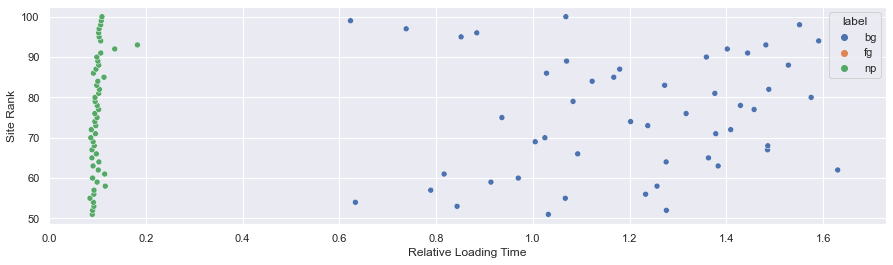

In [113]:
graph_firstRun(df, ["bg", "np"])

bg interval: [0.11033082057418753, 1.9275921255030122]
np_interval: [0.26287622569027336, 0.7671722766778039]


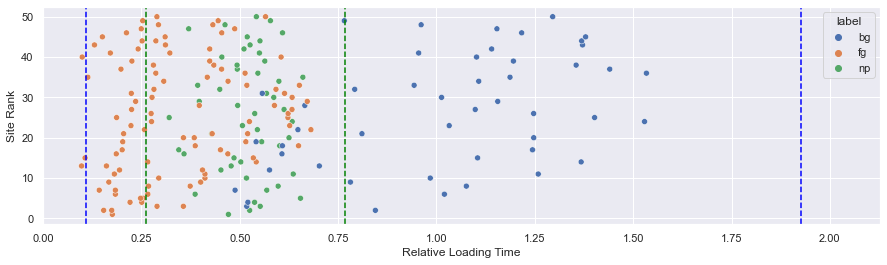

In [98]:
graph_firstRun(df, delta=True, show_outliers=False)

bg interval: [0.11033082057418753, 1.9275921255030122]
np_interval: [0.26287622569027336, 0.7671722766778039]


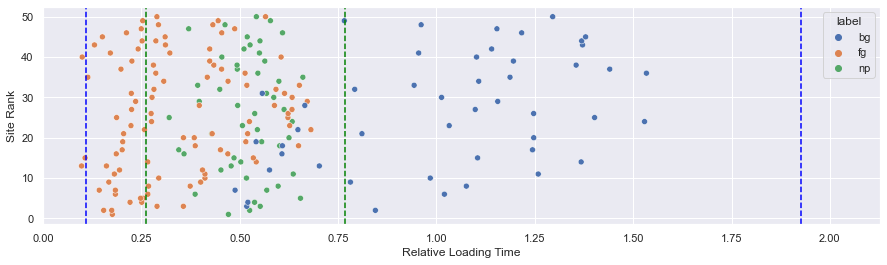

In [100]:
graph_firstRun(df, delta=True, show_outliers=True)

In [101]:
bg_np_acc(df, include_outliers=True)

NP vs BG Accuracy: 1.0


In [102]:
bg_np_acc(df, include_outliers=False)

NP vs BG Accuracy: 1.0


In [37]:
case1, case2 = get_cases(df)

In [67]:
case1

,site,rank,r_time,heavy_load_rtime,html_parsing_time,case,label
101,partner.netflix.net,51,1.031951,0.799763,NaN,1,bg
102,prod.partner.netflix.net,52,1.275906,1.281515,NaN,1,bg
103,fe.apple-dns.net,53,0.843311,0.764732,NaN,1,bg
104,preapp.prod.partner.netflix.net,54,0.633173,1.064306,NaN,1,bg
105,prod.netflix.com,55,1.066990,0.954824,NaN,1,bg
...,...,...,...,...,...,...,...
196,graph.microsoft.com,96,0.311174,0.452145,NaN,1,fg
197,googlesyndication.com,97,0.244825,0.215244,NaN,1,fg
198,app-measurement.com,98,0.365615,0.283070,NaN,1,fg
199,bag.itunes.apple.com,99,0.289139,0.527941,NaN,1,fg


In [39]:
case2

,site,rank,r_time,heavy_load_rtime,html_parsing_time,case,label
0,partner.netflix.net,51,0.368819,NaN,0.001146,2,fg
1,prod.partner.netflix.net,52,0.341701,NaN,0.000148,2,fg
2,fe.apple-dns.net,53,0.349035,NaN,0.000000,2,fg
3,preapp.prod.partner.netflix.net,54,0.347372,NaN,0.000000,2,fg
4,prod.netflix.com,55,0.363182,NaN,0.000156,2,fg
...,...,...,...,...,...,...,...
96,graph.microsoft.com,96,0.102538,NaN,0.000000,2,np
97,googlesyndication.com,97,0.103419,NaN,0.000000,2,np
98,app-measurement.com,98,0.106760,NaN,0.000000,2,np
99,bag.itunes.apple.com,99,0.107792,NaN,0.000062,2,np


In [84]:
svm1 = get_svm(case1, "1")

                                    site  rank    r_time  heavy_load_rtime  \
151                  partner.netflix.net    51  0.518285          1.501165   
152             prod.partner.netflix.net    52  0.280303          1.015737   
153                     fe.apple-dns.net    53  0.109592          0.623576   
154      preapp.prod.partner.netflix.net    54  0.677108          0.487163   
155                     prod.netflix.com    55  0.536032          0.423181   
156                push.prod.netflix.com    56  0.196458          0.662895   
157                     mtalk.google.com    57  0.158034          0.595476   
158                          aaplimg.com    58  0.307150          0.372182   
159                          youtube.com    59  0.211584          0.659422   
160                   gateway.icloud.com    60  0.292579          0.764720   
161                         digicert.com    61  0.195746          0.415650   
162                              msn.com    62  0.294678        

In [ ]:
svm2 = get_svm(case2, "2")

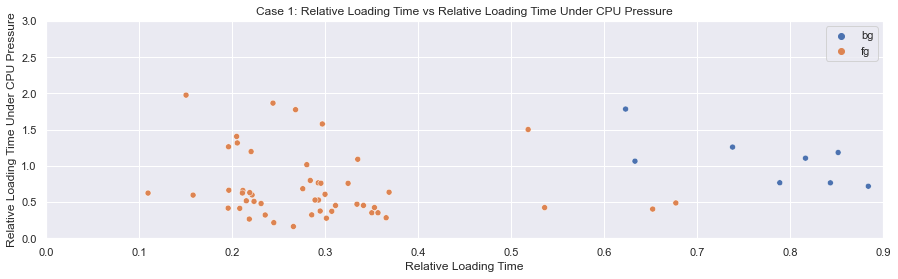

In [85]:
graph_secondRun(df=case1, case="1", svm=svm1, xlim=(0, 0.9), ylim=(-0.0001, 3.0016))

In [ ]:
graph_secondRun(case2, "2", svm=svm2)

In [ ]:
original_df = load_df('results/all_2.csv')
# get r_bg, r_np, and clean dataset
r_bg, r_np, df = cleanup(original_df)
print(f"r_bg:{r_bg}")
print(f"r_np:{r_np}")
graph_firstRun(df, delta=True, types=["np", "bg"], title="NP vs BG", show_outliers=False)

In [ ]:
graph_firstRun(df, delta=True, title="Relative Loading Times", show_outliers=True)

### Trying Different Datasets

In [ ]:
# try Sihan's fg/bg and Mingzhi's np
fg = pd.read_csv('browser-security-sv1/results/frontend.csv', header=None)
bg = pd.read_csv('browser-security-sv1/results/backend.csv', header=None)
np = pd.read_csv('browser-security-sv1/results/np.csv', header=None)

fg['label'] = "fg"
bg['label'] = "bg"
np['label'] = "np"
fg

In [ ]:
sep_df = pd.concat([fg, bg, np])
sep_df

In [ ]:
sep_df = sep_df.rename(columns={1:'r_time', 0:'rank'})
sep_df

In [ ]:
sep_dropped_df = sep_df[:899]
sep_dropped_df

In [ ]:
sns.scatterplot(data=sep_dropped_df, x='r_time', y='rank', hue='label')

In [ ]:
sep_df_no_fg = pd.concat([bg, np]).rename(columns={1:'r_time', 0:'rank'})
sep_df_no_fg

In [ ]:
sns.set(rc={"figure.figsize":(15, 4)}) #width=3, #height=4
sep_df_no_fg = sep_df_no_fg[:599]
sns.scatterplot(data=sep_df_no_fg, x='r_time', y='rank', hue='label')